<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/345_bayesian_prediction.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(bayesian_prediction_notebook)=
# La predizione bayesiana

L'analisi bayesiana ha diversi obiettivi chiave, che includono la formulazione della distribuzione a posteriori dei parametri, la valutazione delle ipotesi e la previsione di dati futuri. Una volta determinate le distribuzioni a posteriori dei parametri, si può procedere a formulare stime riguardo alle possibili caratteristiche di dati futuri. Questo processo porta alla creazione di una *distribuzione predittiva a posteriori*, che serve come strumento essenziale per la verifica e la validazione del modello statistico in uso. Questa distribuzione predittiva permette un confronto diretto tra le previsioni generate dal modello e i dati che sono stati effettivamente osservati nel campione. In pratica, utilizziamo il modello corrente per generare previsioni sui possibili dati futuri e poi confrontiamo queste previsioni con i dati che abbiamo effettivamente raccolto. Se le previsioni generate dal modello sono in buon accordo con i dati osservati, possiamo concludere che il modello fornisce una rappresentazione accurata dei dati.

Una seconda forma di predizione bayesiana riguarda la distribuzione predittiva a priori (*prior predictive distribution*). La distribuzione predittiva a priori rappresenta la distribuzione dei possibili dati osservabili prima di aver effettivamente osservato qualsiasi dato. Essa incorpora la nostra conoscenza a priori, o le nostre credenze iniziali, riguardo ai parametri del modello.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 
import pymc as pm
import pymc.sampling_jax
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

## La distribuzione predittiva a posteriori


Un modo molto intuitivo per valutare la qualità complessiva di un modello è esaminare quanto bene il modello si adatti ai dati reali.  Questo tipo di approccio è diffuso nelle statistiche frequentiste, spesso basato su misure di "badness-of-fit" (inadeguatezza dell'adattamento). Nel contesto delle statistiche Bayesiane, l'analisi dell'adattamento del modello ai dati si avvale del concetto di verifica predittiva a posteriori (*Posterior Predictive Checking*, PPC) {cite:p}`gelman2013philosophy`.

L'idea fondamentale della verifica predittiva a posteriori è che dovrebbe esserci una minima, se non assente, discrepanza tra i dati generati dal modello e i dati reali. In sostanza, la verifica predittiva a posteriori rappresenta un metodo per valutare la qualità della specificazione del modello. Qualsiasi divergenza tra i dati prodotti dal modello e i dati effettivi indica una errata specificazione del modello.

Per esemplificare il concetto di "distribuzione predittiva a posteriori", esploriamo il modello beta-binomiale. In questo contesto, il parametro $\theta$ (che indica la probabilità di successo) segue una distribuzione a priori modellizzata attraverso una distribuzione Beta, mentre la verosimiglianza dei dati è delineata da una distribuzione Binomiale. I dati vengono rappresentati dal numero $y$ di successi in $n$ prove Bernoulliane indipendenti.

Esaminiamo un caso pratico precedentemente discusso, relativo alla rappresentanza di artisti della generazione X o successive al MOMA. In uno specifico campione di 100 artisti, abbiamo notato che solo 14 di essi appartengono a queste generazioni, registrando così 14 "successi" in 100 prove Bernoulliane indipendenti. Ora, immaginiamo di analizzare un nuovo campione casuale di $m$=20 artisti al MOMA, con l'intento di stimare quanti di essi siano della generazione X o successive. In modo più ampio, l'obiettivo è formulare previsioni riguardanti i risultati di futuri campioni potenziali composti da $m$ osservazioni.

Introduciamo la variabile casuale $\tilde{Y}$ che denota il numero di "successi" in un nuovo campione di $m$ prove. In tale campione, $\tilde{Y}$ può assumere valori come $\tilde{y}_1$ (per esempio, 12), $\tilde{y}_2$ (per esempio, 7), e così via. L'obiettivo è di calcolare le probabilità associate a ciascuno dei valori possibili di $\tilde{Y}$, che variano da 0 a 20 inclusi. Questa distribuzione di probabilità discreta è definita come "distribuzione predittiva a posteriori", $p(\tilde{Y} = \tilde{y} \mid Y = y)$, e rappresenta la probabilità di ciascuno dei possibili valori di $\tilde{Y}$ (0, 1, ..., 19, 20) in futuri campioni di $m$ = 20 osservazioni.

In questo capitolo, esploriamo tre strategie per ottenere tale distribuzione:

1. **Approccio analitico**: Risolveremo matematicamente la distribuzione.
2. **Simulazione**: Applicheremo tecniche di simulazione per raggiungere i risultati desiderati.
3. **Campionamento MCMC**: Utilizzeremo il metodo di campionamento MCMC per stimare la distribuzione predittiva a posteriori.

Sebbene i tre metodi conducano agli stessi risultati, è importante notare che l'approccio MCMC facilita l'ottenimento della soluzione, specialmente quando una soluzione analitica non è disponibile, come nei casi al di fuori delle famiglie coniugate.

### Derivazione analitica

Nel contesto in esame, la variabile casuale $ \tilde{Y} $ è governata da una distribuzione che dipende dal parametro $ \theta $. Le informazioni relative a $ \theta $ sono contenute nella distribuzione a posteriori $ p(\theta | y) $. Utilizzando la regola della probabilità congiunta, la distribuzione congiunta delle variabili $ \tilde{y} $ e $ \theta $ può essere rappresentata come:

$$
p(\tilde{y}, \theta | y) = p(\tilde{y} | \theta, y) p(\theta | y).
$$

La distribuzione $ p(\tilde{y}, \theta | y) $ descrive la probabilità congiunta di osservare dati futuri $ \tilde{y} $ e un valore specifico del parametro $ \theta $, dati i dati storici $ y $. Si scompone in due parti:

1. $ p(\tilde{y} | \theta, y) $: la probabilità di osservare $ \tilde{y} $ dato un valore specifico di $ \theta $ e i dati storici $ y $.
2. $ p(\theta | y) $: la distribuzione a posteriori di $ \theta $, che rappresenta una versione aggiornata della nostra conoscenza su $ \theta $ dopo aver osservato i dati $ y $.

Se assumiamo che le osservazioni passate $ y $ e le future $ \tilde{y} $ siano indipendenti, condizionate al valore di $ \theta $, la formula si semplifica in:

$$
p(\tilde{y}, \theta | y) = p(\tilde{y} | \theta) p(\theta | y).
$$

Per ottenere la distribuzione predittiva a posteriori $ p(\tilde{y} | y) $, è necessario integrare la distribuzione congiunta rispetto a $ \theta $. Questo passaggio è noto come "marginalizzazione" e serve a eliminare la dipendenza da $ \theta $:

$$
p(\tilde{y} | y) = \int p(\tilde{y} | \theta) p(\theta | y) \, d\theta.
$$

Nel caso del modello beta-binomiale, $ p(\tilde{y} | \theta) $ è una distribuzione binomiale con parametri $ m $ e $ \theta $, mentre $ p(\theta | y) $ è una distribuzione Beta con parametri $ \alpha + y $ e $ \beta + n - y $.

L'integrazione può essere risolta esplicitamente, data la forma funzionale delle distribuzioni Beta e Binomiale. Il risultato è una formula chiusa per $ p(\tilde{y} | y) $, che rappresenta una distribuzione beta-binomiale.

$$
\begin{align*}
p(\tilde{y} | y) &= \int_0^1 p(\tilde{y} | \theta) p(\theta | y) \, d\theta \\
&= \int_0^1 \binom{m}{\tilde{y}} \theta^{\tilde{y}} (1 - \theta)^{m - \tilde{y}} \cdot \frac{1}{B(\alpha + y, \beta + n - y)} \theta^{\alpha + y - 1} (1 - \theta)^{\beta + n - y - 1} \, d\theta \\
&= \binom{m}{\tilde{y}} \frac{B(\tilde{y} + \alpha + y, \beta + n - y + m - \tilde{y})}{B(\alpha + y, \beta + n - y)}
\end{align*}
$$

In conclusione, nel contesto del modello beta-binomiale, la distribuzione predittiva a posteriori è una distribuzione beta-binomiale con parametri $ m $, $ \alpha + y $, e $ \beta + n - y $:

$$
\begin{equation}
f(\tilde{y} | y) = \binom{m}{\tilde{y}} \frac{B(\alpha + y + \tilde{y}, \beta + n - y + m - \tilde{y})}{B(\alpha + y, \beta + n - y)}.
\end{equation}
$$ (eq-beta-binomial-distr)

È importante notare che, se il nostro modello è ben specificato, la distribuzione predittiva a posteriori e la distribuzione dei dati osservati dovrebbero somigliarsi, essendo governate dalla stessa funzione di densità di probabilità (PDF). Per assicurarsi di questa congruenza, è usuale effettuare verifiche predittive a posteriori, mettendo a confronto la distribuzione predittiva a posteriori con i dati empirici. Un approccio consolidato per tale verifica utilizza le stime di densità Kernel (KDE, dall'inglese Kernel Density Estimates). Una KDE è in pratica una stima empirica della PDF di una variabile aleatoria, basata su un campione finito di dati. Confrontando la KDE derivata dai dati osservati con quella generata dalla distribuzione predittiva a posteriori, siamo in grado di valutare l'adeguatezza del nostro modello nel rappresentare la struttura sottostante dei dati, nonché la sua idoneità per effettuare inferenze future.

#### Un esempio concreto

Nell'esempio riguardante gli artisti della generazione X esposti al MOMA, la funzione di verosimiglianza dei dati è modellata mediante una distribuzione binomiale, registrando 14 successi su un totale di 100 tentativi. La distribuzione a priori per il parametro di successo, indicato come $\theta$, è descritta da una distribuzione Beta con parametri (4, 6). Di conseguenza, la distribuzione a posteriori relativa al parametro $\theta$ sarà una distribuzione Beta con parametri (18, 92).

Ipotizziamo ora di voler determinare la distribuzione predittiva a posteriori per un nuovo campione di dati che comprende $m$ = 20 osservazioni.

Con riferimento all'eq. {eq}`eq-beta-binomial-distr`, sappiamo che la distribuzione predittiva a posteriori assume la forma di una distribuzione beta-binomiale con i parametri $m$, $\alpha + y$ e $\beta + n - y$. Qui, $m$ denota il numero di prove nel nuovo campione, $\alpha$ e $\beta$ rappresentano i parametri della distribuzione a priori, mentre $y$ e $n$ indicano rispettivamente il numero di successi e il numero totale di prove nel campione attuale. Nell'esempio in esame, otteniamo i seguenti valori per i parametri della distribuzione beta-binomiale: $m = 20$, $\alpha' = 4 + 14 = 18$, $\beta' = 6 + 100 - 14 = 92$.

Possiamo rappresentare graficamente la distribuzione predittiva a posteriori che abbiamo definito usando la funzione `betabinom.pmf`.

Text(0.5, 1.0, 'Beta-Binomial PMF')

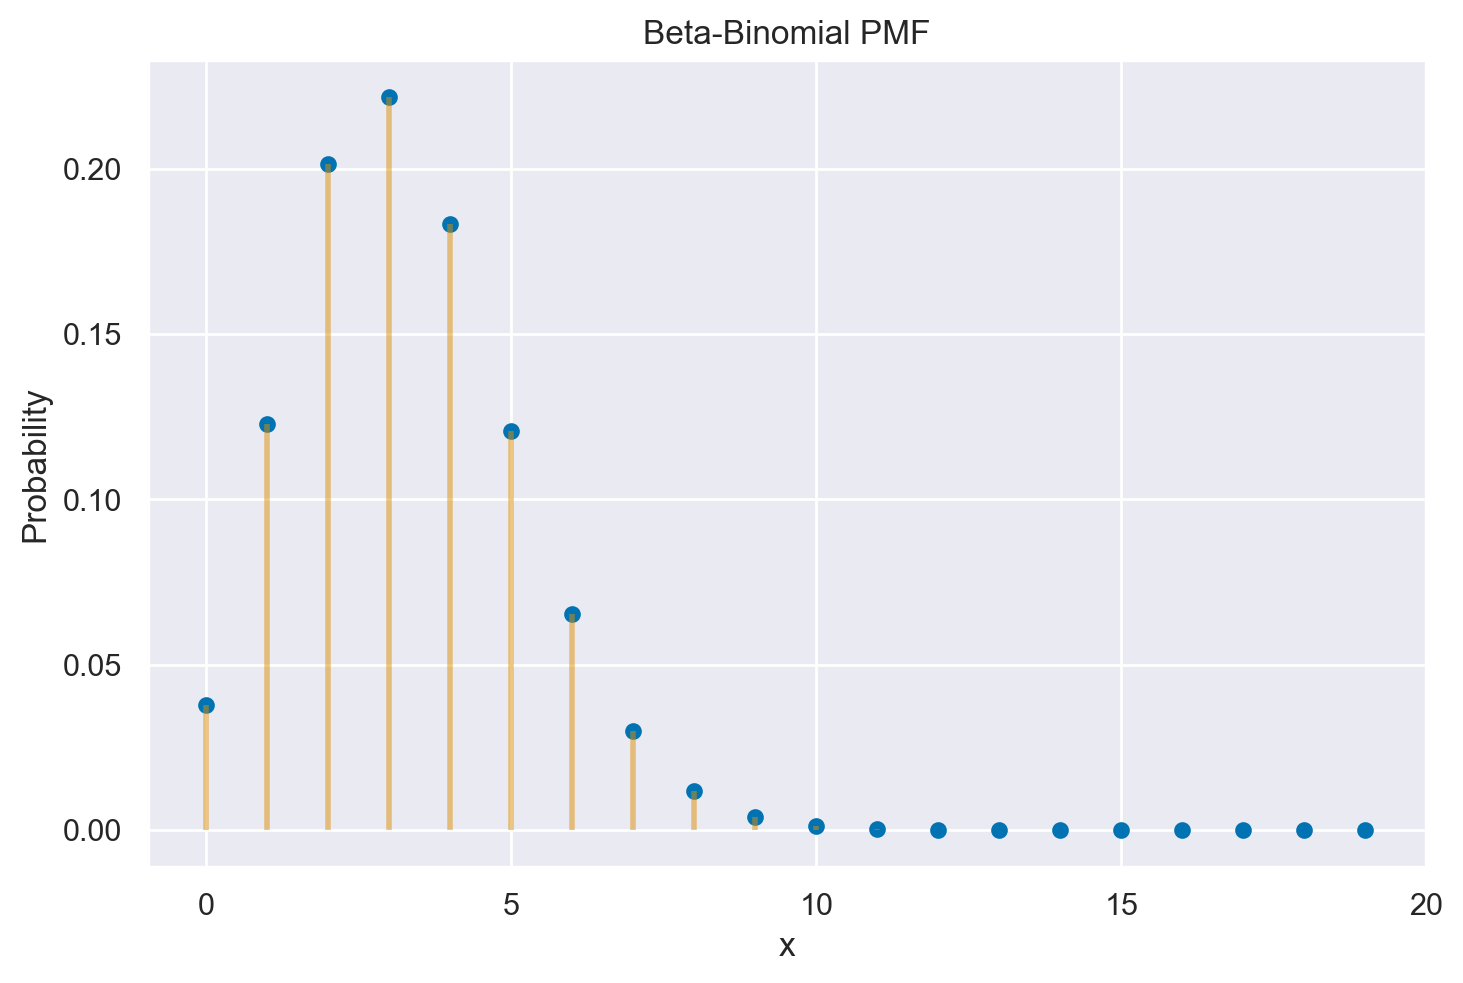

In [20]:
alpha = 4
beta = 6
y = 14
n = 100
alpha_prime = alpha + y
beta_prime = beta + n - y
m = 20
x = np.arange(0, 20)

plt.plot(
    x,
    stats.betabinom.pmf(x, m, alpha_prime, beta_prime),
    "C0o",
    ms=5,
    label="betabinom pmf",
)
_ = plt.vlines(
    x,
    0,
    stats.betabinom.pmf(x, m, alpha_prime, beta_prime),
    colors="C1",
    lw=2,
    alpha=0.5,
)

# Set x-ticks to be every 5 units
plt.xticks(np.arange(0, 21, 5))

plt.xlabel("x")
plt.ylabel("Probability")
plt.title("Beta-Binomial PMF")

La distribuzione predittiva a posteriori, mostrata nella figura precedente, fornisce informazioni sulla probabilità di osservare $0, 1, \dots, 20$ successi su $m = 20$ prove in un futuro campione di $m$ = 20 osservazioni. Queste probabilità sono valutate tenendo conto dei dati osservati nel campione corrente (14 successi su 100 prove) e delle nostre opinioni iniziali sulla plausibilità dei possibili valori di $\theta$ (rappresentate dalla distribuzione a priori Beta(4, 6)). In altre parole, la distribuzione predittiva a posteriori ci offre una visione delle possibili frequenze di successo che potremmo osservare nei futuri campioni, basandoci sulle nostre conoscenze attuali e sull'esperienza passata.

La distribuzione predittiva a posteriori rivela che, nei potenziali campioni futuri composti da 20 osservazioni, il valore $\tilde{y}$ con la probabilità più elevata è 3. Tuttavia, la distribuzione predittiva a posteriori ci fornisce informazioni sulla probabilità relativa di ciascuno dei possibili valori futuri di $\tilde{y}$. Questi valori rappresentano il numero di artisti della Generazione X o successive che potrebbero trovarsi all'interno di un futuro campione di 20 osservazioni.

Una volta ottenuta la distribuzione predittiva a posteriori possiamo rispondere a ulteriori domande. Ad esempio, Qual è la probabilità a posteriori che almeno 5 degli 20 artisti siano della generazione X, ossia $P(\tilde{Y} \geq 5 \mid Y = 14)$?

Il risultato è dato da $\sum_i(P(\tilde{Y} = \tilde{y}_i)$, con $i \in 5, \dots, 20$.

In [21]:
1 - stats.betabinom.cdf(4, m, alpha_prime, beta_prime).sum()

0.23298739435887628

È altresì possibile calcolare il valore atteso della distribuzione predittiva a posteriori, cioè il numero previsto di artisti appartenenti alla Generazione X o successiva in un campione casuale di 20.

In [22]:
x = np.arange(0, 21)
px = stats.betabinom.pmf(np.arange(0, 21), m, alpha_prime, beta_prime)

ev = sum(x * px)
print(ev)

3.272727272727284


In conclusione, per il caso beta-binomiale, possiamo affermare che la previsione bayesiana di una nuova osservazione futura è rappresentata dalla distribuzione beta-binomiale con parametri $m$, $\alpha + y$ e $\beta + n - y$. Qui, $m$ rappresenta il numero di prove nel nuovo campione, $\alpha$ e $\beta$ sono i parametri della distribuzione a priori, e $y$ e $n$ sono le caratteristiche del campione attuale. In altre parole, la distribuzione beta-binomiale ci fornisce una stima delle possibili frequenze di successi che potremmo osservare in futuri campioni, tenendo conto dei dati osservati e delle nostre conoscenze iniziali sulla probabilità di successo.

### Metodo basato sulla simulazione

In situazioni in cui non è possibile ottenere esattamente la distribuzione predittiva a posteriori, è comunque possibile ottenere un campione casuale di valori dalla distribuzione mediante simulazione. Nel caso in esame, supponiamo di voler generare un campione casuale di $n$ osservazioni dalla distribuzione predittiva a posteriori. Per farlo, possiamo seguire due fasi di simulazione:

1. Estraiamo casualmente $n$ valori del parametro $\theta$ dalla distribuzione a posteriori $p(\theta \mid y)$.
2. Utilizziamo i valori del parametro $\theta$ estratti per generare $n$ valori casuali di $\tilde{y}$, utilizzando il modello binomiale con i parametri $m$ e $\theta_i$ (con $i = 1, \dots, n$).

In questo modo, otteniamo $n$ realizzazioni casuali di $n$ distribuzioni binomiali, ciascuna con i parametri specificati sopra, le quali rappresentano un campione casuale di valori della distribuzione predittiva a posteriori.

Vediamo come ottenere questo risultato in pratica. Per l'esempio che stiamo discutendo, la distribuzione a posteriori di $\theta$ è una Beta(25, 17). Procediamo con l'estrazione casuale di 100,000 valori da questa distribuzione e esaminiamo i primi 10 valori:

In [23]:
nrep = 100000
theta = stats.beta.rvs(alpha_prime, beta_prime, size=nrep)
print(*theta[0:10])

0.17247681101824086 0.13357356357273387 0.11801388963090914 0.1267245857491376 0.16989856533166858 0.14047333538865384 0.12950079536832976 0.1722233247390301 0.1698886721400558 0.11905001371123933


Per ciascuno dei 100,000 valori estratti per $\theta$, generiamo casualmente un valore dalla distribuzione binomiale con parametri $n = 20$ e probabilità $\theta$. Esaminiamo i primi 50 valori così ottenuti.

In [6]:
y_tilde = [stats.binom.rvs(n=20, p=th, size=1) for th in theta]
y_tilde = np.concatenate(y_tilde)
print(*y_tilde[0:50])

2 0 3 3 5 0 3 3 8 4 6 1 2 4 5 3 4 2 1 4 6 4 2 2 4 2 4 9 1 5 1 1 6 2 2 5 3 1 3 5 3 2 5 6 3 4 2 2 6 5


L'insieme dei valori `y_tilde` costituisce un campione casuale dalla distribuzione predittiva a posteriori. Nella figura seguente, è presentato un istogramma che mostra la distribuzione dei valori `y_tilde`. I punti corrispondenti alla distribuzione predittiva a posteriori corretta, ossia una distribuzione Beta-Binomiale con parametri $m = 20$, $\alpha' = 18$, e $\beta' = 92$, sono sovrapposti sull'istogramma. Si può notare una quasi perfetta concordanza tra i valori ottenuti tramite la simulazione e quelli ricavati con la derivazione analitica.

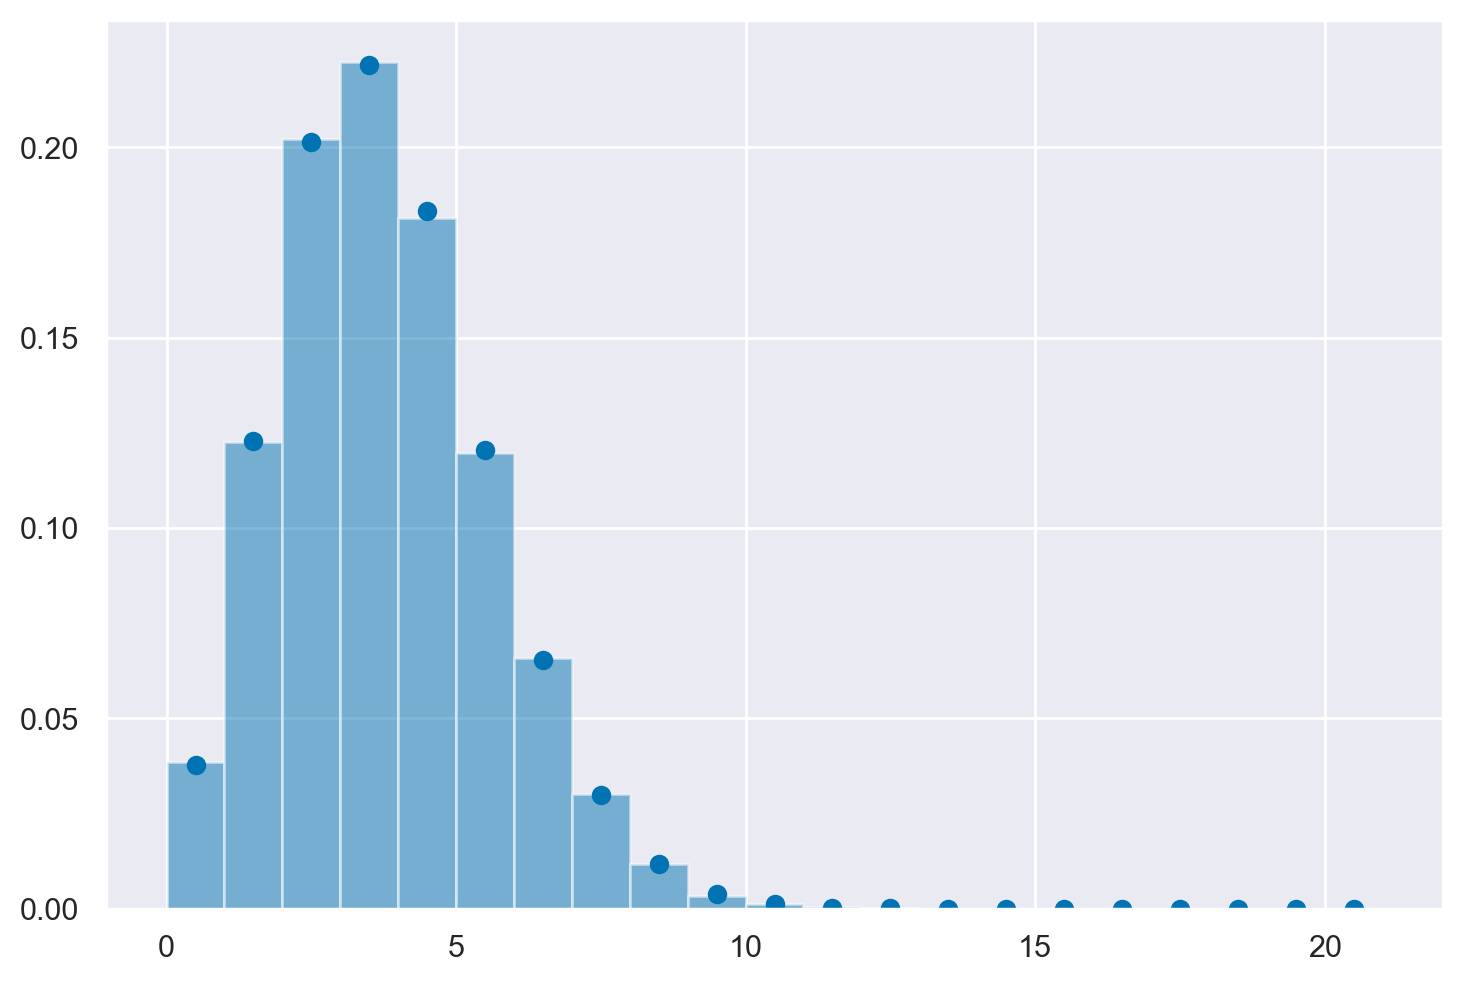

In [24]:
hist, bins, _ = plt.hist(y_tilde, bins=range(0, 22), density=True, alpha=0.5)
bin_centers = (bins[:-1] + bins[1:]) / 2
px = stats.betabinom.pmf(np.arange(0, 21), m, alpha_prime, beta_prime)
plt.plot(bin_centers, px, "o", color="C0", label="Beta-Binomial");

Un intervallo di credibilità all'80% si può facilmente ottenere usando ArviZ.

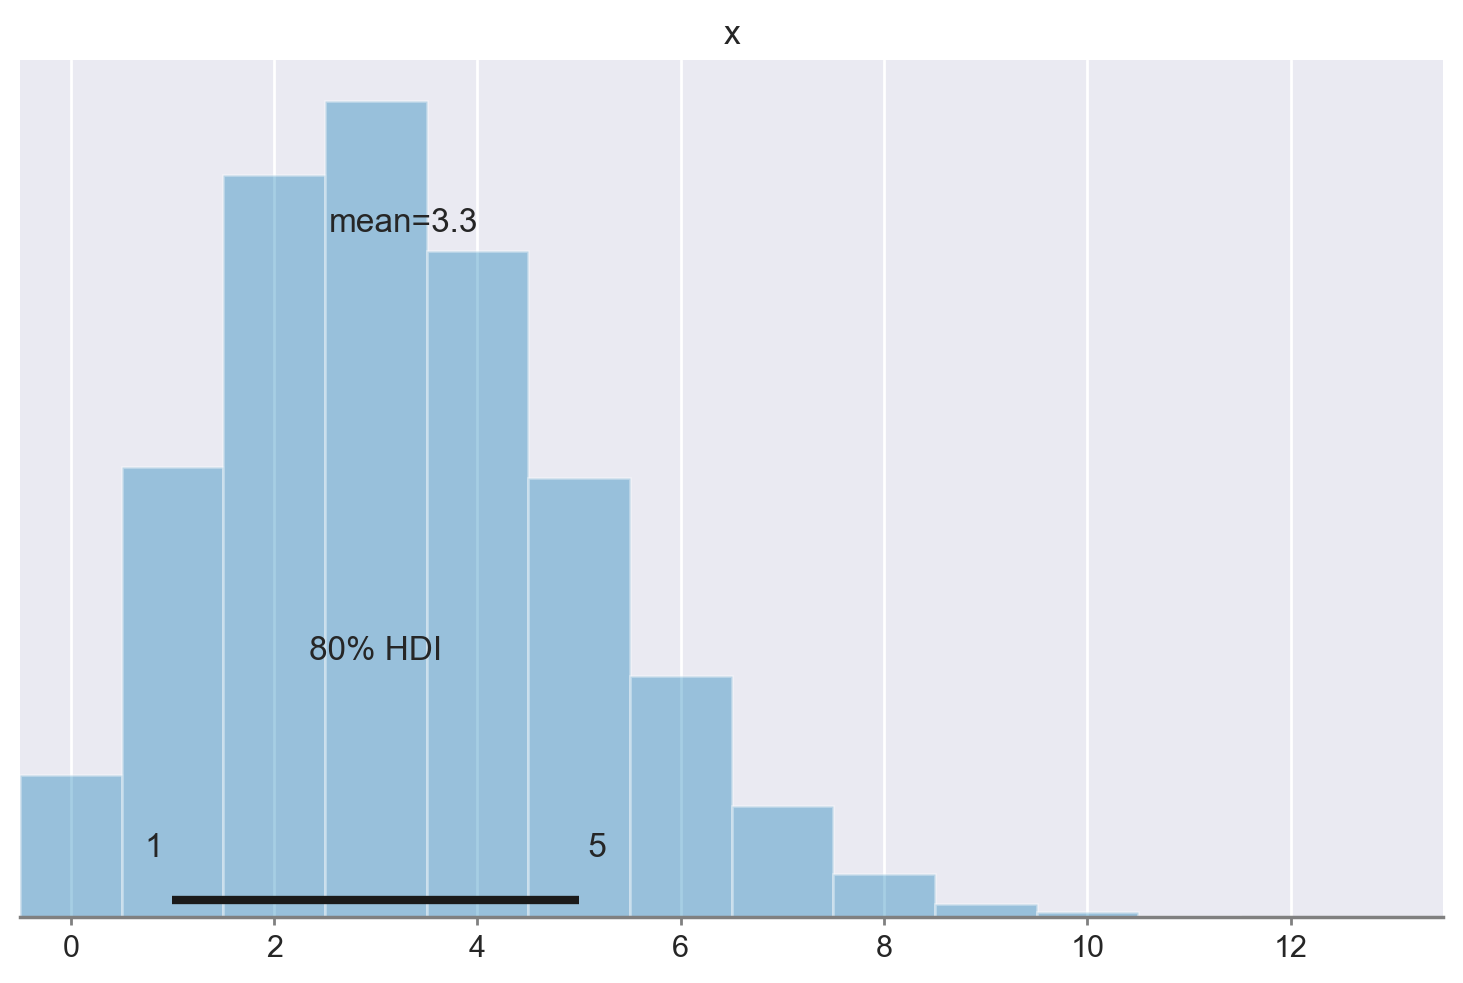

In [25]:
az.plot_posterior(y_tilde, hdi_prob=0.8, kind="kde", bw=0.5);

Possiamo concludere affermando che, nel caso in cui analizzassimo un nuovo campione di 20 artisti provenienti dal MOMA, ci potremmo attendere che solamente 3 di questi artisti facciano parte della generazione X o di una generazione successiva. Tuttavia, è importante sottolineare che questa stima è soggetta a un certo grado di incertezza. Considerando un livello di fiducia soggettivo dell'80%, l'intervallo di variabilità stimato va da un minimo di 1 ad un massimo di 5 artisti, che potrebbero essere rappresentativi di queste generazioni successive. 

## Metodo MCMC

Il metodo di simulazione discusso sopra segue la stessa logica utilizzata dai metodi MCMC per ottenere un'approssimazione della distribuzione predittiva a posteriori. Mediante i metodi MCMC, vengono stimate le possibili osservazioni future $p(\tilde{y} \mid y)$, rappresentate come $p(y^{rep} \mid y)$, attraverso i seguenti passaggi:

1. Campionare $\theta_i \sim p(\theta \mid y)$: Viene selezionato casualmente un valore del parametro dalla distribuzione a posteriori.
2. Campionare $y^{rep} \sim p(y^{rep} \mid \theta_i)$: Viene selezionata casualmente un'osservazione dalla funzione di verosimiglianza, condizionata al valore del parametro ottenuto nel passo precedente.

Ripetendo questi due passaggi un numero sufficiente di volte, l'istogramma risultante approssimerà la distribuzione predittiva a posteriori. In alcuni casi, come nel presente esempio, è possibile ottenere analiticamente la distribuzione predittiva a posteriori. In altre situazioni, invece, l'utilizzo dei metodi MCMC consente di ottenere un'approssimazione accurata della distribuzione predittiva a posteriori quando una derivazione analitica non è possibile.

Esaminiamo ora come ottenere la distribuzione predittiva a posteriori con PyMC per i dati dell'esempio. Iniziamo a creare la distribuzione a posteriori di $\theta$.

In [26]:
ntrials = 100
y = 14

alpha_prior = 4
beta_prior = 6

with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

In [27]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time = 0:00:00.363252
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1787.07it/s]
Sampling time = 0:00:01.272512
Transforming variables...
Transformation time = 0:00:00.035954


In [28]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.165,0.035,0.099,0.23,0.001,0.001,1615.0,1596.0,1.0


Il processo della simulazione descritta in precedenza può essere automatizzato usando PyMC, ma solo per un campione futuro avente la stessa ampiezza del campione presente ($n = m$ = 100). Le istruzioni necessarie per generare la distribuzione predittiva a posteriori, $y^{rep} \sim p(y^{rep} \mid \theta_i)$ sono fornite di seguito.

In [29]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs]


Esaminiamo il risultato ottenuto.

In [13]:
post_pred.posterior_predictive.obs

<xarray.DataArray 'obs' (chain: 4, draw: 1000)>
array([[20, 17, 16, ..., 23, 16, 10],
       [15, 13, 19, ..., 15, 21, 22],
       [20, 19, 25, ..., 30, 11, 16],
       [16, 13, 15, ..., 25, 17, 12]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

Creiamo un istogramma con i dati $y^{rep}$. L'intervallo di credibilità dell'80% è [9, 21].

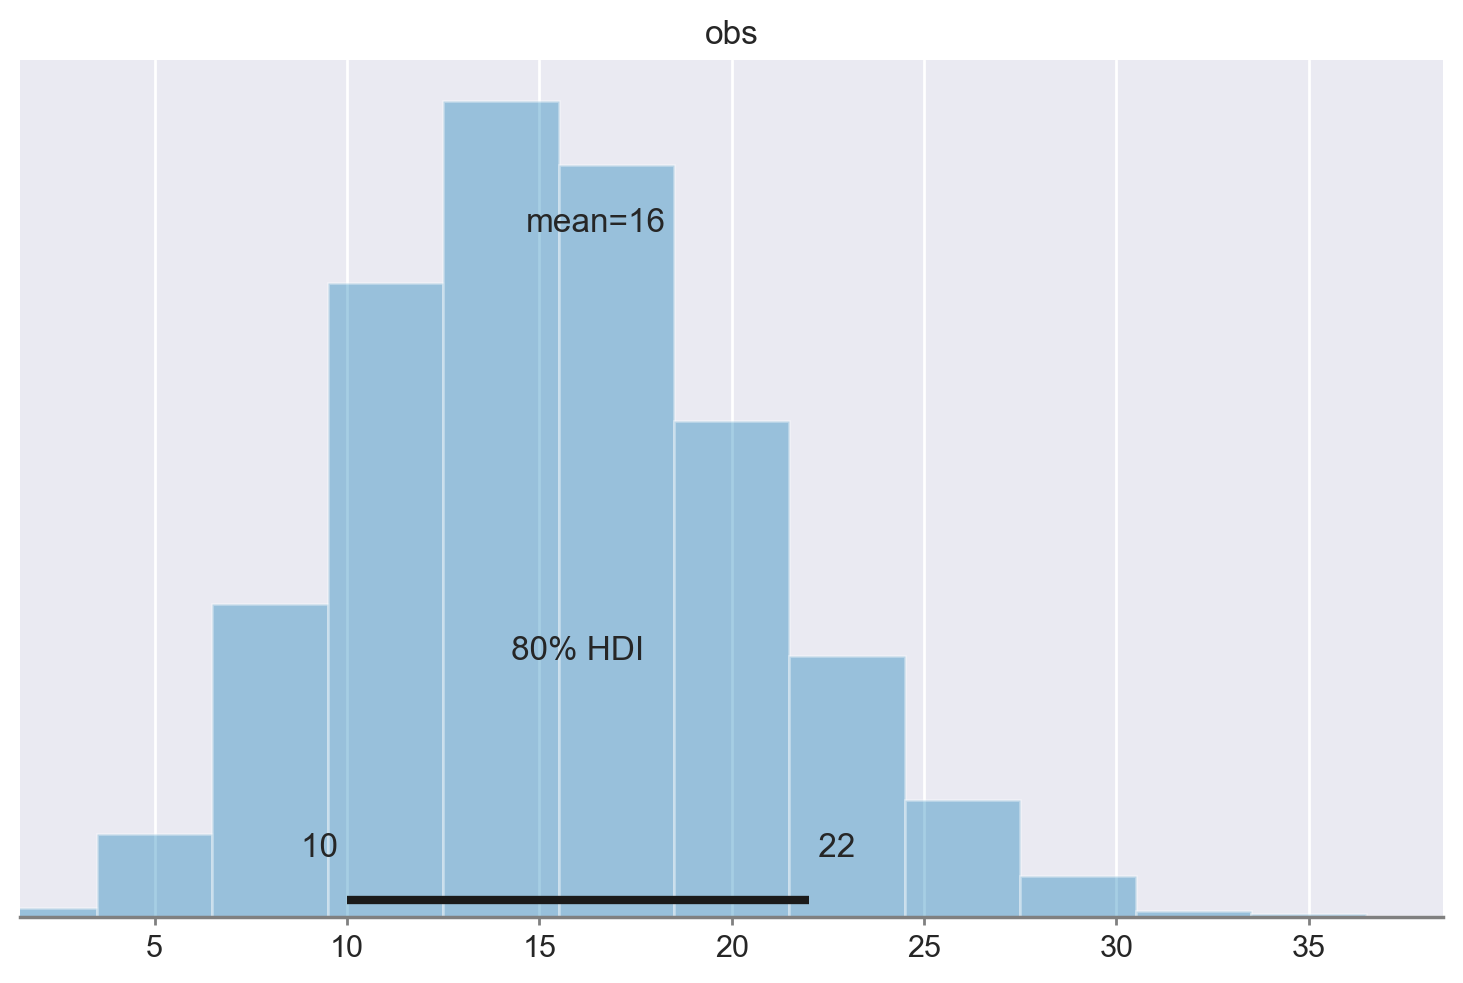

In [30]:
az.plot_posterior(post_pred.posterior_predictive.obs, hdi_prob=0.8)
plt.show()

Se invece vogliamo una distribuzione predittiva a posteriori nel caso di $m$ = 20 dobbiamo procedere svolgendo i calcoli "manualmente".

Il modello predittivo a posteriori riflette due fonti di variabilità:

- la prima fonte di variabilità riguarda la varianza della distribuzione binomiale $\tilde{Y} \mid \pi \sim \text{Binomiale}(20, \pi)$;
- la seconda fonte di variabilità riguarda l'incertezza su $\pi$ che è espressa dalla distribuzione a posteriori di questo parametro.

Per considerare entrambe le fonti di variabilità nelle previsioni a posteriori di $\tilde{Y}$, possiamo impiegare `stats.binom.rvs` per simulare un singolo risultato $\tilde{Y}$ dalla distribuzione Binomiale(20, $\theta$) per ciascuno dei 4000 valori nella catena di Markov relativa a $\theta$.

Iniziamo combinando catene e iterazioni della catena di Markov in un unico vettore.

In [31]:
post = az.extract(idata)
post["theta"].size

4000

Generiamo poi un valore casuale dalla distribuzione Binomiale di parametri $n$ = 20 e $\theta$, per ciascuno dei 4000 valori $\theta$ della distribuzione a posteriori. Il vettore così risultante sarà un campione dalla distribuzione predittiva a posteriori, nel caso di un'ampiezza campionaria pari a 20.

In [32]:
y_rep = stats.binom.rvs(n=20, p=post["theta"])

Usiamo ArviZ per creare un istogramma della distribuzione di `y_rep` e per trovare l'intervallo di credibilità all'80%.

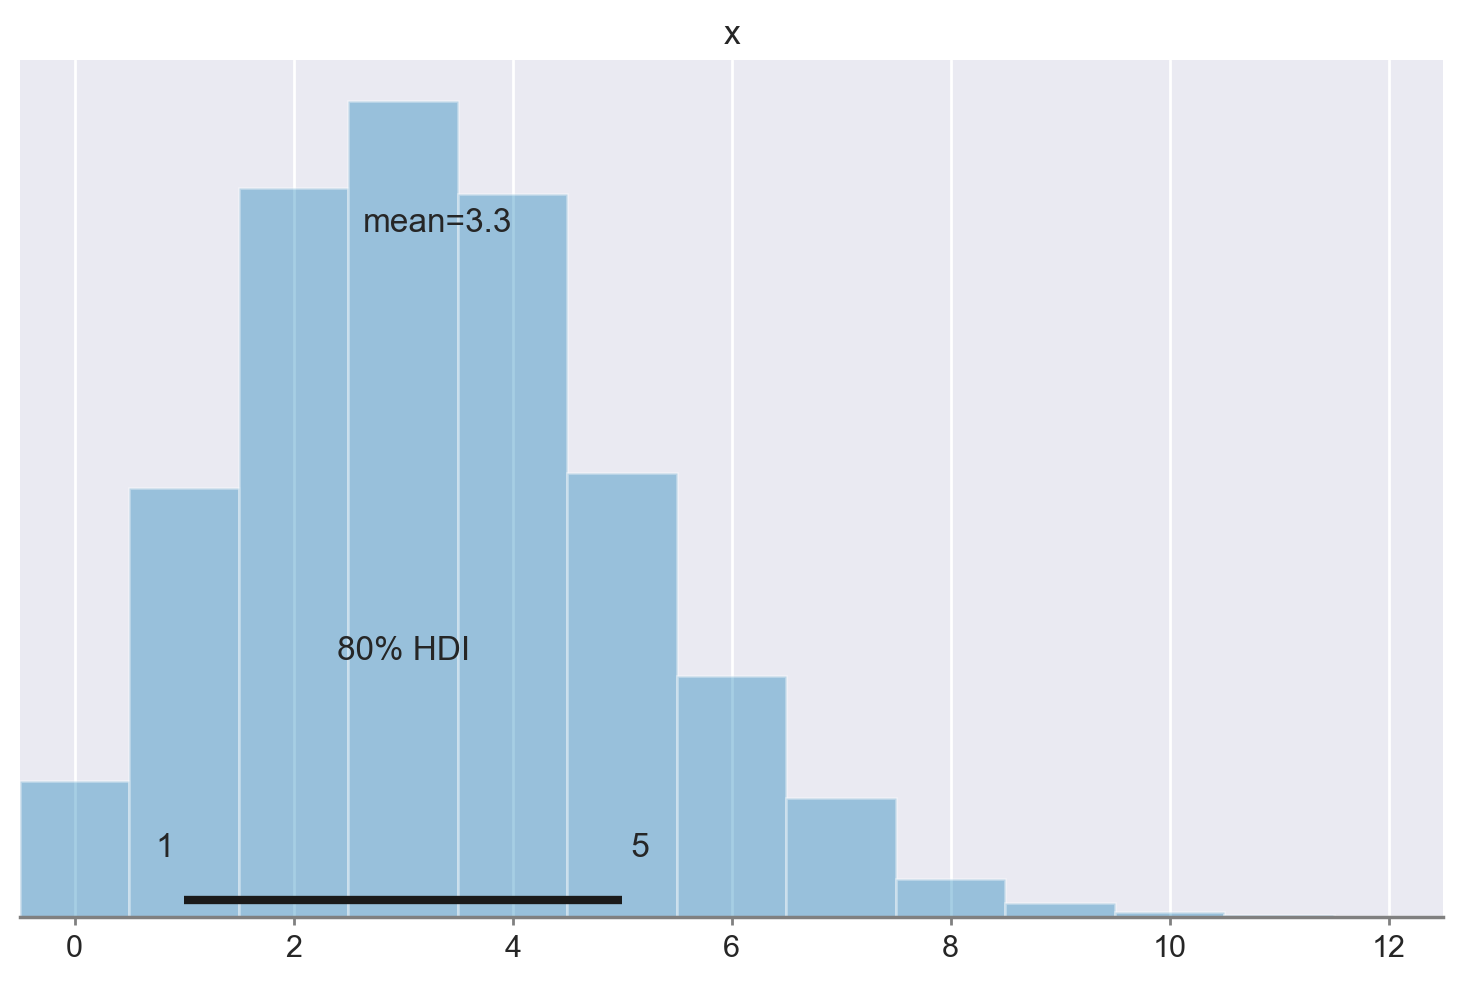

In [33]:
az.plot_posterior(y_rep, hdi_prob=0.8, kind="kde", bw=0.5)
plt.show()

### Posterior predictive checks

La distribuzione predittiva a posteriori è utilizzata per eseguire i *controlli predittivi a posteriori* (PPC), noti come *Posterior Predictive Checks*. I PPC consistono in un confronto grafico tra $p(y^{rep} \mid y)$, ossia la distribuzione delle osservazioni future previste, e i dati osservati $y$. Questo confronto visivo permette di valutare se il modello utilizzato è adeguato per descrivere le proprietà dei dati osservati.

Oltre al confronto grafico tra le distribuzioni $p(y)$ e $p(y^{rep})$, è possibile effettuare un confronto tra le distribuzioni di varie statistiche descrittive calcolate su diversi campioni $y^{rep}$ e le corrispondenti statistiche calcolate sui dati osservati. Tipicamente, vengono considerate statistiche descrittive come la media, la varianza, la deviazione standard, il minimo o il massimo, ma è possibile confrontare qualsiasi altra statistica rilevante.

I controlli predittivi a posteriori offrono un valido strumento per un'analisi critica delle prestazioni del modello e, se necessario, per apportare eventuali modifiche o considerare modelli alternativi più adatti ai dati in esame.

## Distribuzione predittiva a priori

Prima di procedere con un'analisi Bayesiana completa, è cruciale valutare l'adeguatezza della distribuzione a priori, specie alla luce di una preesistente conoscenza del dominio che può permettere di scartare distribuzioni a priori manifestamente erronee. Questa metodologia di valutazione delle distribuzioni a priori è conosciuta come verifica predittiva a priori, ed è stata introdotta inizialmente da {cite:t}`box1980sampling` e successivamente promossa da {cite:t}`gelman2017prior`.

Nella sezione precedente, abbiamo esaminato l'uso della distribuzione predittiva per rappresentare l'incertezza relativa alla distribuzione di futuri dati osservabili. Tale distribuzione predittiva incorpora sia la distribuzione a posteriori del parametro $\theta$ che la scelta del modello basata sui dati precedentemente osservati. Un concetto affine, ma distinto, è la *distribuzione predittiva a priori*, che proietta le aspettative sulle future osservazioni del modello, prima dell'acquisizione di qualsiasi dato. Questa distribuzione è definita dalla seguente espressione matematica:

$$
p(y) = \int p(y \mid \theta) p(\theta) d\theta,
$$

dove
- $p(y \mid \theta)$ rappresenta la funzione di verosimiglianza, ovvero la dipendenza dei dati dai parametri,
- $p(\theta)$ è la distribuzione a priori dei parametri, che manifesta le nostre credenze iniziali riguardo ai valori dei parametri.

Se i dati osservati discostano significativamente dalla distribuzione predittiva a priori, ciò può indicare una possibile inadeguatezza nel modello Bayesiano (relativa alla distribuzione a priori, al meccanismo generativo dei dati, o entrambi). In pratica, ciò suggerisce che, data la formulazione del modello Bayesiano, i dati effettivamente osservati risultano improbabili, il che potrebbe implicare un'insufficienza del modello.

La distribuzione predittiva a priori risulta utile per molteplici motivi:

- *Esplorazione delle credenze iniziali:* permette di investigare come le credenze iniziali sui parametri (es. la probabilità di ottenere testa nel lancio di una moneta) si traducano in aspettative concrete riguardo agli esiti osservabili.
- *Confronto con dati reali:* confrontando i dati effettivamente osservati con la distribuzione predittiva a priori, è possibile valutare l'adeguatezza del modello e delle credenze a priori.
- *Analisi di sensibilità:* la distribuzione predittiva a priori può anche illustrare quanto le conclusioni del modello siano sensibili alle diverse scelte della distribuzione a priori.

La distribuzione predittiva a priori può essere ottenuta mediante metodi MCMC, replicando il procedimento utilizzato per la distribuzione predittiva a posteriori, ma in assenza di dati osservati.

Nell'esempio con i dati di {cite:t}`zetsche_2019future`, se avessimo scelto una distribuzione Beta(2, 10) come a priori, l'analisi predittiva a priori avrebbe potuto rivelare che questa scelta non era adeguata per i dati considerati. Questo esempio dimostra come la distribuzione predittiva a priori possa servire come potente strumento diagnostico nell'analisi bayesiana, aiutando a guidare e rifinire le scelte del modello.

Ritorniamo all'esempio con i dati degli artisti della generazione X al MOMA. Per questi dati abbiamo scelto una distribuzione a priori Beta(4, 6) per il parametro di successo $\theta$. 

In [18]:
print(alpha_prior, beta_prior)

4 6


Eseguiamo l'analisi predittiva a priori con `sample_prior_predictive`.

In [19]:
with model:
    idata_prior_pred = pm.sample_prior_predictive()

Sampling: [obs, theta]


Esaminiamo l'oggetto `idata_prior_pred` che abbiamo creato.

In [20]:
idata_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

I dati (sulla scala delle osservazioni $y$) sono contenuti in `idata.prior_predictive.obs`. Possiamo usare `arviz` per generare un istogramma della distribuzione predittiva a priori usando la funzione `plot_posterior`:

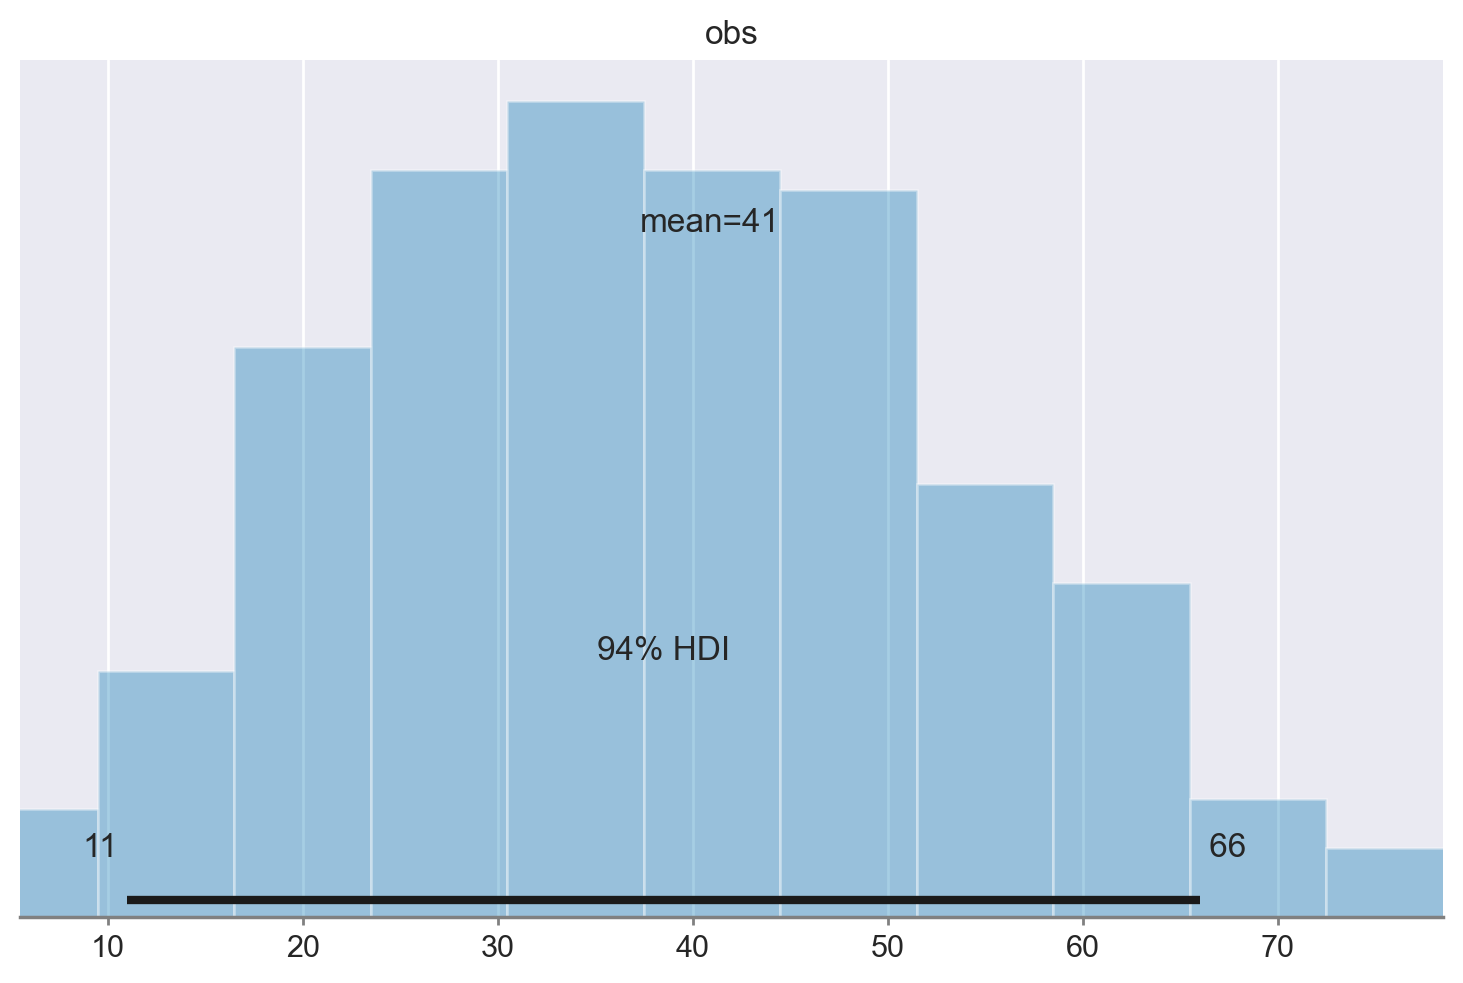

In [21]:
az.plot_posterior(idata_prior_pred.prior_predictive.obs)
plt.show()

La regione dell'intervallo di credibilità ad alta densità (HDI) al 94% è [9, 67]. Nel nostro campione, abbiamo osservato un valore di $y$ = 14. Poiché questo risultato rientra nell'intervallo di credibilità della distribuzione predittiva a priori, possiamo dedurre che la scelta di una distribuzione Beta(4, 6) come distribuzione a priori sembra essere adeguata per i dati in questione.

### Esempio con Stan

Per sviluppare un'intuizione relativa alla distribuzione predittiva a priori, consideriamo il seguente codice Stan, il quale mira a stimare i parametri di una distribuzione gaussiana. Nonostante non sia necessario avere una conoscenza approfondita della sintassi Stan, è possibile comprendere l'essenza del processo. Nel codice, viene specificata solo la dimensione del campione, `n`, senza fornire i dati effettivi. Vengono definiti i prior per i parametri $\mu$ e $\sigma$. Nel blocco `generated quantities`, viene generata la distribuzione predittiva a priori.

Il codice illustra che, per il numero `n` dell'ampiezza campionaria specificata, si estrae un valore casuale da una distribuzione gaussiana, la cui media e deviazione standard sono a loro volta estratte casualmente dalle distribuzioni a priori specificate per $\mu$ e $\sigma$. Questo processo produce `n` valori, e viene ripetuto 1000 o più volte, a seconda del numero di iterazioni specificate in Stan, per ottenere una rappresentazione della distribuzione predittiva a priori.

```stan
mod <-"
    data {
        int n;  // Dimensione del campione
    }

    parameters {
        real<lower=0> mu;  // Media
        real<lower=0> sigma;  // Deviazione standard
    }

    model {
        // Distribuzioni a priori
        mu ~ normal(400,1);  // Prior per la media
        sigma ~ normal(100,5);  // Prior per la deviazione standard
    }

    generated quantities {
        vector[n] prior_rep;  // Vettore per contenere la distribuzione predittiva a priori
        // Generazione della distribuzione predittiva a priori
        for(i in 1:n) {
            prior_rep[i] = normal_rng(mu,sigma);  // Estrazione di un valore casuale dalla distribuzione gaussiana
        } 
    }
"
```
In questo modo, il codice Stan fornisce un mezzo per esplorare e comprendere come i prior sui parametri della distribuzione gaussiana influenzano la distribuzione predittiva a priori, anche senza un insieme di dati osservati.

## Watermark

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Tue Jan 23 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

matplotlib: 3.8.2
arviz     : 0.17.0
seaborn   : 0.13.0
scipy     : 1.11.4
pandas    : 2.1.4
pymc      : 5.10.3
numpy     : 1.26.2

Watermark: 2.4.3

